In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data( ) 

In [10]:
X_train.shape

(60000, 28, 28)

In [8]:
X_test.shape

(10000, 28, 28)

In [ ]:
#생성자 모델 만들기
generator = Sequential()

# 128*7*7 = 6272개의 노드를 가진 1차원 행렬, input_dom이 1차원값 100을 나타냄으로
# Dense를 통과하면 (batch_size, 6272)의 1차원 배열
# batch_size는 컴파일할때 또는 학습할떄 정의됨
# 이미지 크기를 7로 하는것은 최종 단계의 이미지가 28이라는 점을 고려해서 설정한 값이다.
# 업샘플링 두번 (*4)를 하면 최종값인 28이 나오기떄문에
# 128은 모델이 학습할 수 있는 표현력과 관련
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))

# 평균과 표준편차 계산하여 데이터를 정규화
generator.add(BatchNormalization())

#학습에 필요한 텐서형태(다차원 형태)로 변환하기 위해 reshape
#가로,세로,깊이 의 형태// 깊이는 처음에 Dense에서 설정한 값
generator.add(Reshape((7,7,128)))

# 입력 텐서의 가로와 세로 크기를 두배 늘리는 작업 - 해상도 올리는 작업, 기본값으로 2,2 설정
# 단순히 텐서의 늘리는 것으로 이후 컨볼루션으로 값을 채운다
generator.add(UpSampling2D())


# Conv2D(필터수, 커널사이즈, 옵션)
# 필터수=> 학습할 개수 및 출력 개수, 커널사이즈=> 한번에 학습하는 공간의 크기
# padding=same => 출력 텐서의 크기를 유지, 부족하면 0으로 채움
# 커널 사이즈를 5로 지정했기 때문에, padding=same을 안하면 사이즈가 5*5로 줄어버림
generator.add(Conv2D(64,kernel_size=5, padding='same'))

# 평균과 표준편차 계산하여 데이터를 정규화
generator.add(BatchNormalization())
#음수값 소실을 방지하기위해서 작은 기울기를 유지
generator.add(Activation(LeakyReLU(0.2)))

generator.add(UpSampling2D())

#최종 필터가 1인 이유는 이미지가 흑백이기 때문에, 최종 이미지가 컬러라면 3 입력.
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [14]:
#판별자 모델 만들기
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainabel=False #판별자는 판별만, 학습 X

In [20]:
#생성자와 판별자 모델을 연결시키는 gan 모델 만들기
ginput = Input(shape=100,)
dis_output = discriminator(generator(ginput))
gan = Model(ginput,dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_5 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 1,065,474
Non-trainable params: 12,672
_________________________________________________________________


epoch : 0, d_loss : 0.5988, g_los : 0.0427
1/1 [==============================] - 0s 13ms/step
epoch : 100, d_loss : 0.0008, g_los : 28.5386
epoch : 200, d_loss : 0.1872, g_los : 18.1554
1/1 [==============================] - 0s 12ms/step
epoch : 300, d_loss : 2.5237, g_los : 24.4785
epoch : 400, d_loss : 0.8040, g_los : 19.5586
1/1 [==============================] - 0s 9ms/step
epoch : 500, d_loss : 2.5668, g_los : 16.8255
epoch : 600, d_loss : 0.7457, g_los : 39.1117
1/1 [==============================] - 0s 11ms/step
epoch : 700, d_loss : 3.2713, g_los : 53.3689
epoch : 800, d_loss : 4.4162, g_los : 108.5301
1/1 [==============================] - 0s 12ms/step
epoch : 900, d_loss : 2.4409, g_los : 130.4544
epoch : 1000, d_loss : 4.4191, g_los : 125.3057
1/1 [==============================] - 0s 12ms/step
epoch : 1100, d_loss : 9.8000, g_los : 124.9135
epoch : 1200, d_loss : 7.4379, g_los : 160.5799
1/1 [==============================] - 0s 12ms/step
epoch : 1300, d_loss : 12.9366, g_

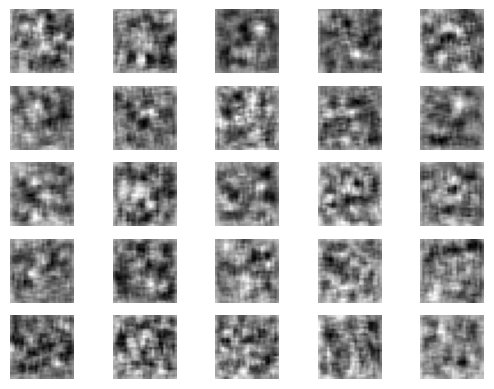

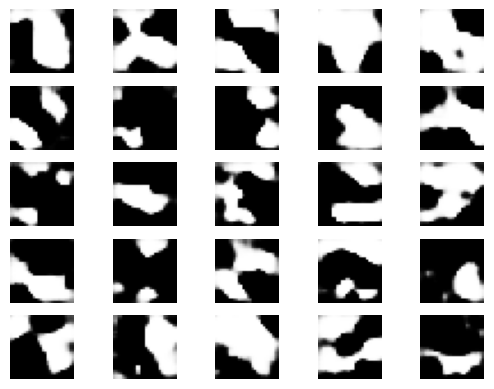

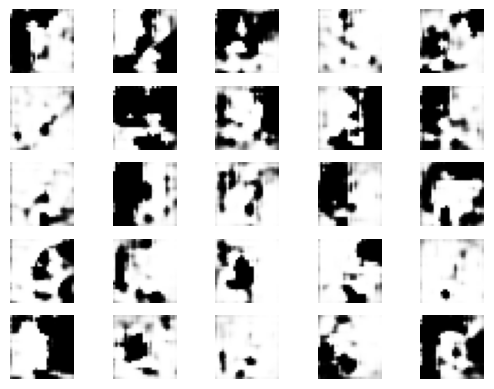

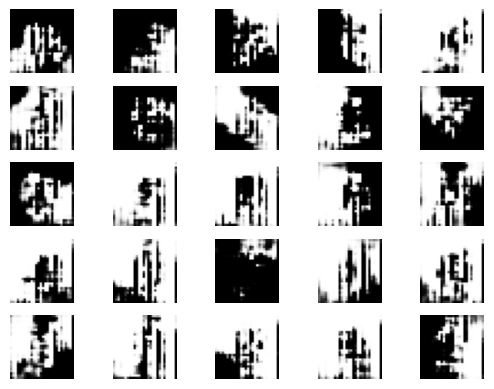

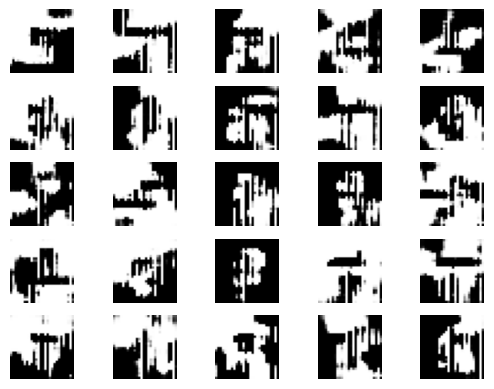

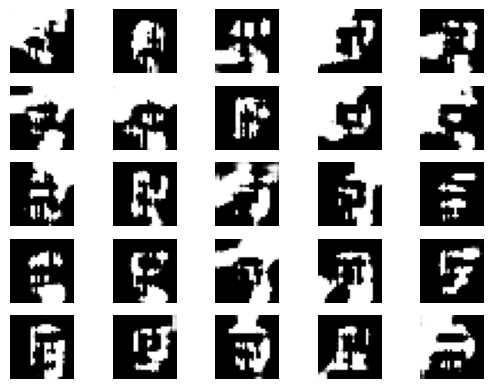

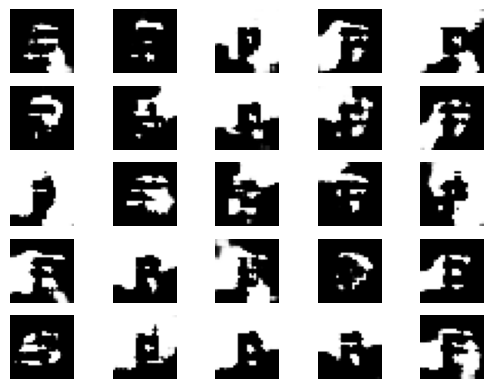

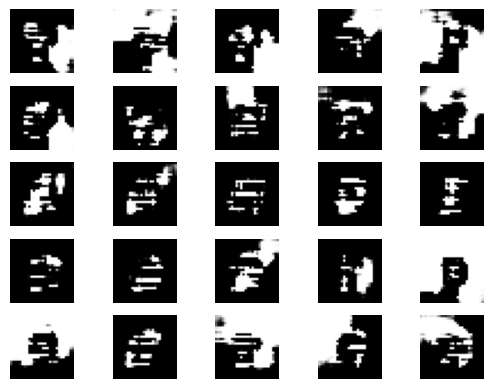

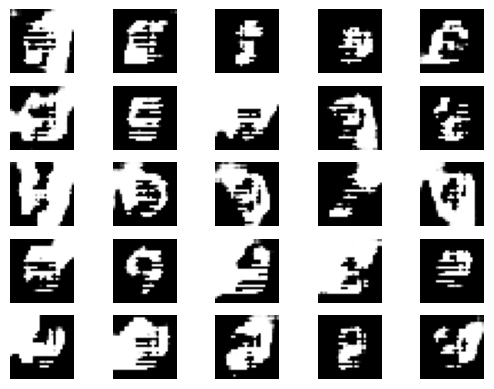

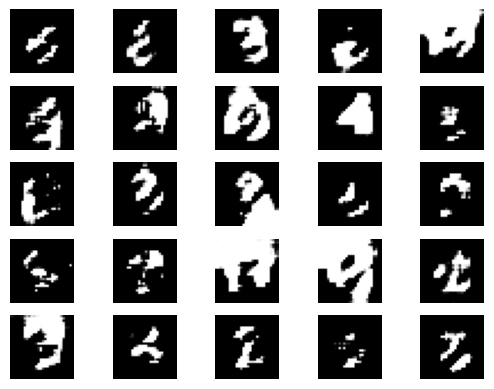

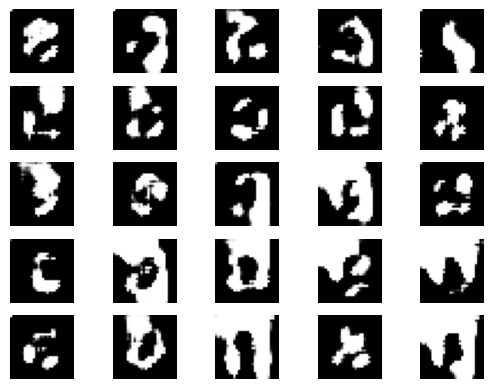

In [22]:
#신경망을 실행시키는 함수 만들기
def gan_train(epoch, batch_size, saving_interval):

  #MNIST데이터 불러오기
  (X_train, _), (_,_)= mnist.load_data()
  #MNIST의 이미지만 쓸꺼라서 X_train하나만 불러오기
  X_train = X_train.reshape(X_train.shape[0], 28,28,1).astype('float32')
  
  #전체적인 값이 -1 ~ 1 사이에 들어올 수 있도록 빼고 나눠주기
  #마지막에 사용할 활성화함수 tanh의 범위가 -1 ~ 1 이기 때문에
  X_train = (X_train - 127.5) / 127.5

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
    #실제 데이터를 판별자에 입력하는 부분
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)

    #가상 이미지를 판별자에 입력하는 부분
    noise = np.random.normal(0, 1, (batch_size,100))
    gen_imgs= generator.predict(noise, verbose=0)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

    #판별자와 생성자의 오차 계산
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    g_loss = gan.train_on_batch(noise,true)

    if i % 100 == 0:
      print( f'epoch : {i}, d_loss : {d_loss:.4f}, g_los : {g_loss:.4f}')


    #중간 과정을 이미지로 저장해주는 부분, 만들어진 이미지는 gan_images폴더에 저장
    if i % saving_interval ==0:
      noise = np.random.normal (0, 1, (25,100))
      gen_imgs = generator.predict(noise)

      #resalce imges 0 - 1
      gen_imgs = 0.5 * gen_imgs + 0.5

      fig,axs = plt.subplots(5,5)
      count=0
      for j in range(5):
        for k in range(5):
          axs[j,k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
          axs[j,k].axis('off')
          count +=1
      fig.savefig(f'./gan_mnist_{i}.png')


gan_train(2001, 32, 200)

## 이미지의 특징을 추출하는 오토인코더

In [23]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

import matplotlib.pyplot as plt
import numpy as np

In [24]:
#MNIST 데이터셋 불러오기
(X_train, _), (X_test, _)= mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28,28,1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28,28,1).astype('float32') / 255

In [27]:
#생성자 모델 만들기
autoencoder = Sequential()

#인코딩
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8,kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

In [28]:
#디코딩
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3,activation='sigmoid'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

autoencoder.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 4, 4, 8)           584       
                                                                 
 conv2d_13 (Conv2D)          (None, 4, 4, 8)          

In [29]:
#컴파일, 학습
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test,X_test))

Epoch 1/50
469/469 [==============================] - 3s 5ms/step - loss: 0.2397 - val_loss: 0.1620
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1448 - val_loss: 0.1306
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1252 - val_loss: 0.1198
Epoch 4/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1168 - val_loss: 0.1130
Epoch 5/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1118 - val_loss: 0.1085
Epoch 6/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1081 - val_loss: 0.1059
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1053 - val_loss: 0.1030
Epoch 8/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1031 - val_loss: 0.1010
Epoch 9/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1013 - val_loss: 0.0996
Epoch 10/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0997 - val_loss: 0.0980

313/313 [==============================] - 1s 2ms/step


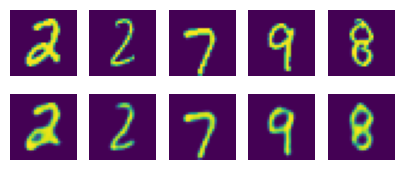

In [34]:
#학습된 결과 출력
random_test = np.random.randint(X_test.shape[0], size=5)
ae_imgs = autoencoder.predict(X_test)
plt.figure(figsize=(7,2))

for i, image_idx in enumerate(random_test):
  ax=plt.subplot(2,7, i+1)
  plt.imshow(X_test[image_idx].reshape(28,28))
  ax.axis('off')
  ax=plt.subplot(2,7,7+i+1)
  plt.imshow(ae_imgs[image_idx].reshape(28,28))
  ax.axis('off')
plt.show()